Data source:
https://www.kaggle.com/saurograndi/airplane-crashes-since-1908

This dataset includes:

- All civil and commercial aviation accidents of scheduled and non-scheduled passenger airliners worldwide, which resulted in a fatality (including all U.S. Part 121 and Part 135 fatal accidents)
- All cargo, positioning, ferry and test flight fatal accidents.
- All military transport accidents with 10 or more fatalities.
- All commercial and military helicopter accidents with greater than 10 fatalities.
- All civil and military airship accidents involving fatalities.
- Aviation accidents involving the death of famous people.
- Aviation accidents or incidents of noteworthy interest.

Info about dataset:
- Date - Date of the crash
- Time - Time of the crash
- Location - Location of the crash
- Operator - Airline of the plane
- Flight - Flight no. of the plane
- Route - Route taken by plane
- Type - Type of the plane
- Registration - Unique alphanumeric string to identify the plane
- cn/In - Construction or serial number / Line or fuselage number
- Aboard - Number of people aboard
- Fatalities - Lethal outcome
- Ground - Total ground people killed due to crash.
- Summary - Brief summary of the case

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from gensim import corpora, models

from collections import Counter

import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk import bigrams
import string

from wordcloud import WordCloud
from PIL import Image
import urllib
import requests

In [2]:
data = pd.read_csv('Airplane_Crashes_and_Fatalities_Since_1908.csv')
data.head(3)

,Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary
0,09/17/1908,17:18,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2.0,1.0,0.0,"During a demonstration flight, a U.S. Army fly..."
1,07/12/1912,06:30,"AtlantiCity, New Jersey",Military - U.S. Navy,NaN,Test flight,Dirigible,NaN,NaN,5.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...
2,08/06/1913,NaN,"Victoria, British Columbia, Canada",Private,-,NaN,Curtiss seaplane,NaN,NaN,1.0,1.0,0.0,The first fatal airplane accident in Canada oc...


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5268 entries, 0 to 5267
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          5268 non-null   object 
 1   Time          3049 non-null   object 
 2   Location      5248 non-null   object 
 3   Operator      5250 non-null   object 
 4   Flight #      1069 non-null   object 
 5   Route         3562 non-null   object 
 6   Type          5241 non-null   object 
 7   Registration  4933 non-null   object 
 8   cn/In         4040 non-null   object 
 9   Aboard        5246 non-null   float64
 10  Fatalities    5256 non-null   float64
 11  Ground        5246 non-null   float64
 12  Summary       4878 non-null   object 
dtypes: float64(3), object(10)
memory usage: 535.2+ KB


In [4]:
data.describe()

,Aboard,Fatalities,Ground
count,5246.000000,5256.000000,5246.000000
mean,27.554518,20.068303,1.608845
std,43.076711,33.199952,53.987827
min,0.000000,0.000000,0.000000
25%,5.000000,3.000000,0.000000
50%,13.000000,9.000000,0.000000
75%,30.000000,23.000000,0.000000
max,644.000000,583.000000,2750.000000


In [5]:
print('% of Missing values in columns')
(len(data)-data.count())/(len(data))*100

% of Missing values in columns


Date             0.000000
Time            42.122248
Location         0.379651
Operator         0.341686
Flight #        79.707669
Route           32.384207
Type             0.512528
Registration     6.359150
cn/In           23.310554
Aboard           0.417616
Fatalities       0.227790
Ground           0.417616
Summary          7.403189
dtype: float64

### Primary data exploration

Highest Fatalities and Accidents by operator

In [6]:
operator = data[['Operator', 'Fatalities']]

In [7]:
operator.groupby('Operator').agg(['sum', 'count'])

Fatalities      
                                     sum count
Operator                                      
A B Aerotransport                    3.0     2
AB Aerotransport                    58.0     3
ACES Colombia                       40.0     3
ADC Airlines                        97.0     2
ADES Colombia                       22.0     2
...                                  ...   ...
Zantop Air Transport                13.0     4
Zantop Airways                       2.0     1
Zantop International Airlines        4.0     1
Zen Nippon                           2.0     1
de Havilland Aircraft               11.0     1

[2476 rows x 2 columns]

In [8]:
operator = operator.groupby('Operator').agg(['sum', 'count'])

In [9]:
accidents = operator['Fatalities', 'count'].sort_values(ascending=False)
accidents

Operator
Aeroflot                                               179
Military - U.S. Air Force                              176
Air France                                              69
Deutsche Lufthansa                                      65
United Air Lines                                        44
                                                      ... 
Military - U.S. Air Force / Military -  U.S. Army        1
Military - U.S. Air Force / Military U.S. Air Force      1
Military - U.S. Air Force/Military - U.S. Air Force      1
L & J Company                                            1
Military - Ejército del Aire                             0
Name: (Fatalities, count), Length: 2476, dtype: int64

In [10]:
total_acc = accidents.sum()
frac_acc = accidents/total_acc

In [11]:
fatalities = operator['Fatalities', 'sum'].sort_values(ascending=False)
total_fat = fatalities.sum()
frac_fat = fatalities/total_fat

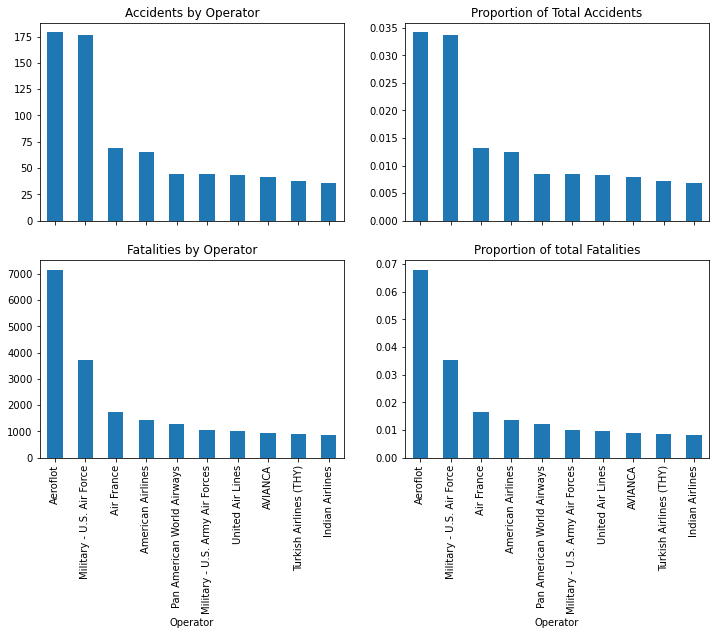

In [12]:
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)
fig_ops,((ax1, ax2), (ax3, ax4))= plt.subplots(2,2,sharex=True)


accidents.head(10).plot(kind='bar',title='Accidents by Operator',ax=ax1,rot=90)
frac_acc.head(10).plot(kind='bar',title='Proportion of Total Accidents',ax=ax2,rot=90)


fatalities.head(10).plot(kind='bar',title='Fatalities by Operator',ax=ax3,rot=90)

frac_fat.head(10).plot(kind='bar',title='Proportion of total Fatalities',ax=ax4,rot=90);

### time analysis

In [13]:
data['Date'] = pd.to_datetime(data['Date'])

In [14]:
data['Day'] = data['Date'].apply(lambda x: x.day)
data['Month'] = data['Date'].apply(lambda x: x.month)
data['Year'] = data['Date'].apply(lambda x: x.year)
data.drop('Date', axis = 1, inplace = True)

In [15]:
data.head()

,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary,Day,Month,Year
0,17:18,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2.0,1.0,0.0,"During a demonstration flight, a U.S. Army fly...",17,9,1908
1,06:30,"AtlantiCity, New Jersey",Military - U.S. Navy,NaN,Test flight,Dirigible,NaN,NaN,5.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...,12,7,1912
2,NaN,"Victoria, British Columbia, Canada",Private,-,NaN,Curtiss seaplane,NaN,NaN,1.0,1.0,0.0,The first fatal airplane accident in Canada oc...,6,8,1913
3,18:30,Over the North Sea,Military - German Navy,NaN,NaN,Zeppelin L-1 (airship),NaN,NaN,20.0,14.0,0.0,The airship flew into a thunderstorm and encou...,9,9,1913
4,10:30,"Near Johannisthal, Germany",Military - German Navy,NaN,NaN,Zeppelin L-2 (airship),NaN,NaN,30.0,30.0,0.0,Hydrogen gas which was being vented was sucked...,17,10,1913


Feature engineering that is connected with time

In [16]:
#extract yearly data
freq_year = {}
for row in data['Year']:
    if row in freq_year:
        freq_year[row] +=1
    else:
        freq_year[row] = 1

#sort dictionary by values and store keys and corresponding values
freq_year = {k: v for k, v in sorted(freq_year.items(), key=lambda item: item[1], reverse=True)}
years = list(freq_year.keys())
crashes_year = list(freq_year.values())

In [17]:
#extract daily data
freq_day = {}
for row in data['Day']:
    if row in freq_day:
        freq_day[row] +=1
    else:
        freq_day[row] = 1

#sort dictionary by values and store keys and corresponding values
freq_day = {k: v for k, v in sorted(freq_day.items(), key=lambda item: item[1], reverse=True)}
days = list(freq_day.keys())
crashes_day = list(freq_day.values())

In [18]:
def get_season(month):
    if month >= 3 and month <= 5:
        return 'spring'
    elif month >= 6 and month <= 8:
        return 'summer'
    elif month >= 9 and month <= 11:
        return 'autumn'
    else:
        return 'winter'

data['Season'] = data['Month'].apply(get_season)

In [19]:
#extract seasonal data
freq_season = {}
for row in data['Season']:
    if row in freq_season:
        freq_season[row] +=1
    else:
        freq_season[row] = 1

#sort dictionary by values and store keys and corresponding values
freq_season = {k: v for k, v in sorted(freq_season.items(), key=lambda item: item[1], reverse=True)}
season = list(freq_season.keys())
crashes_season = list(freq_season.values())

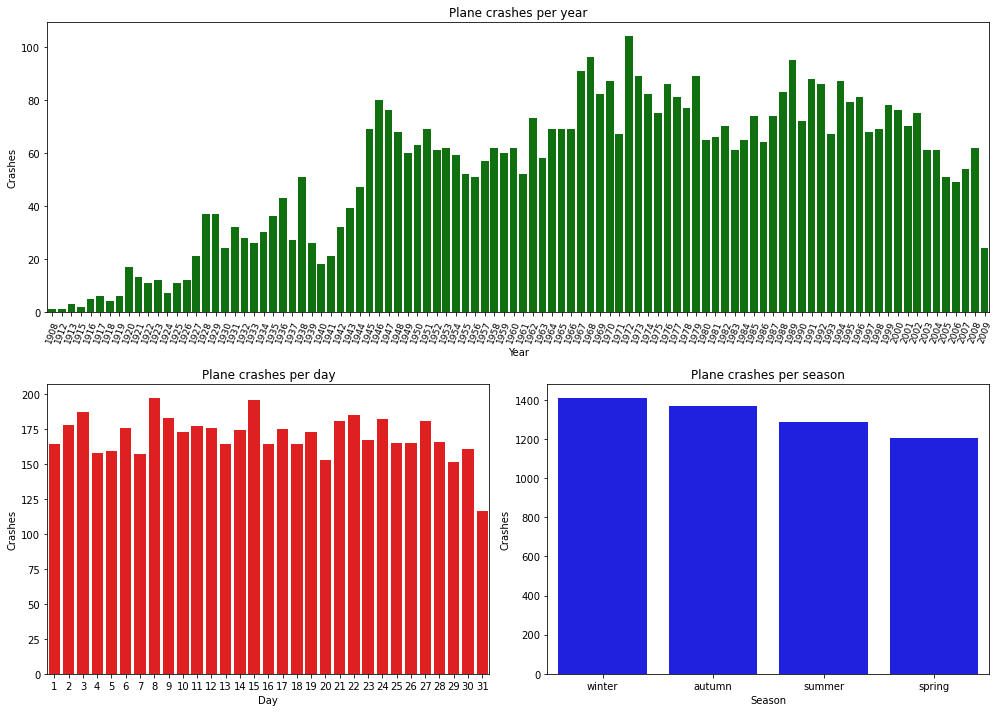

In [20]:
fig = plt.figure(figsize=(14, 10))

sub1 = fig.add_subplot(211)
sns.barplot(x=years, y=crashes_year, color='g', ax=sub1)
sub1.set(ylabel="Crashes", xlabel="Year", title="Plane crashes per year")
plt.setp(sub1.patches, linewidth=0)
plt.setp(sub1.get_xticklabels(), rotation=70, fontsize=9)

sub2 = fig.add_subplot(223)
sns.barplot(x=days, y=crashes_day, color='r', ax=sub2)
sub2.set(ylabel="Crashes", xlabel="Day", title="Plane crashes per day")

sub3 = fig.add_subplot(224)
sns.barplot(x=season, y=crashes_season, color='b', ax=sub3)
texts = sub3.set(ylabel="Crashes", xlabel="Season", title="Plane crashes per season")

plt.tight_layout()

In [21]:
data['Operator'].value_counts()

Aeroflot                            179
Military - U.S. Air Force           176
Air France                           70
Deutsche Lufthansa                   65
United Air Lines                     44
                                   ... 
Loma Linda University - Air Taxi      1
Overseas National Airways             1
Bimini Air Charter Inc.               1
Skystream Airlines                    1
Condor Flugdienst                     1
Name: Operator, Length: 2476, dtype: int64

In [22]:
temp = data.copy()
temp['Operator'] = temp['Operator'].apply(lambda s:s.lower() if type(s) == str else s)


In [23]:
temp['isMilitary'] = temp['Operator'].str.contains('military')

In [24]:
# temp

In [25]:
temp = temp.groupby('isMilitary')[['isMilitary']].agg('count')
temp.index = ['Passenger', 'Military']
temp

,isMilitary
Passenger,4469
Military,781


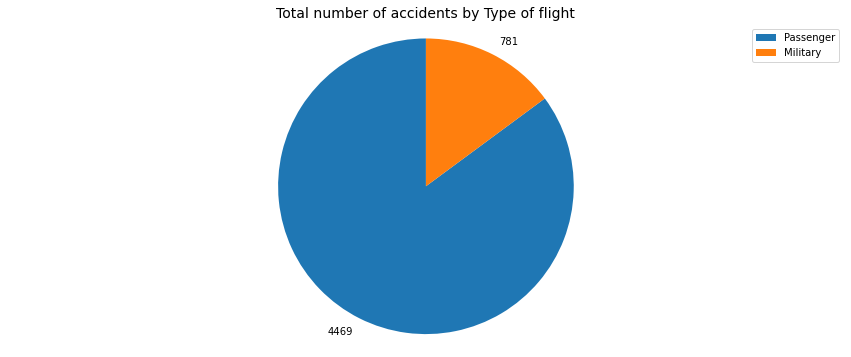

In [26]:
plt.figure(figsize=(15,6))


plt.pie(temp['isMilitary'],  labels=temp['isMilitary'], startangle=90)
plt.legend(temp.index, loc="best", fontsize=10)
plt.axis('equal')
plt.title('Total number of accidents by Type of flight', loc='Center', fontsize=14);



**analysis by location**

In [27]:
data['Location']

0                                     Fort Myer, Virginia
1                                 AtlantiCity, New Jersey
2                      Victoria, British Columbia, Canada
3                                      Over the North Sea
4                              Near Johannisthal, Germany
                              ...                        
5263                               Near Madiun, Indonesia
5264                    Near Isiro, DemocratiRepubliCongo
5265    AtlantiOcean, 570 miles northeast of Natal, Br...
5266         Near Port Hope Simpson, Newfoundland, Canada
5267                    State of Arunachal Pradesh, India
Name: Location, Length: 5268, dtype: object

In [28]:
freq_location = {}
for row in data['Location']:
    if row in freq_location:
        freq_location[row] +=1
    else:
        freq_location[row] = 1

In [29]:
len(freq_location)

4304

In [30]:
#sort dictionary by values and store keys and corresponding values

freq_location = {k:v for k, v in sorted(freq_location.items(), key = lambda item: item[1], reverse=True)}



In [31]:
items = freq_location.items()

In [32]:
# items

In [33]:
location, crashes_location = zip(*items)
loc_cr = pd.DataFrame(data = items, columns=['location', 'num of accidents'])

In [34]:
loc_cr

,location,num of accidents
0,NaN,20
1,"Sao Paulo, Brazil",15
2,"Moscow, Russia",15
3,"Rio de Janeiro, Brazil",14
4,"Bogota, Colombia",13
...,...,...
4299,"Near Madiun, Indonesia",1
4300,"Near Isiro, DemocratiRepubliCongo",1
4301,"AtlantiOcean, 570 miles northeast of Natal, Br...",1
4302,"Near Port Hope Simpson, Newfoundland, Canada",1


In [35]:
loc_cr.replace(np.nan, 'unknown loc', regex=True, inplace = True)

In [36]:
loc_cr

,location,num of accidents
0,unknown loc,20
1,"Sao Paulo, Brazil",15
2,"Moscow, Russia",15
3,"Rio de Janeiro, Brazil",14
4,"Bogota, Colombia",13
...,...,...
4299,"Near Madiun, Indonesia",1
4300,"Near Isiro, DemocratiRepubliCongo",1
4301,"AtlantiOcean, 570 miles northeast of Natal, Br...",1
4302,"Near Port Hope Simpson, Newfoundland, Canada",1


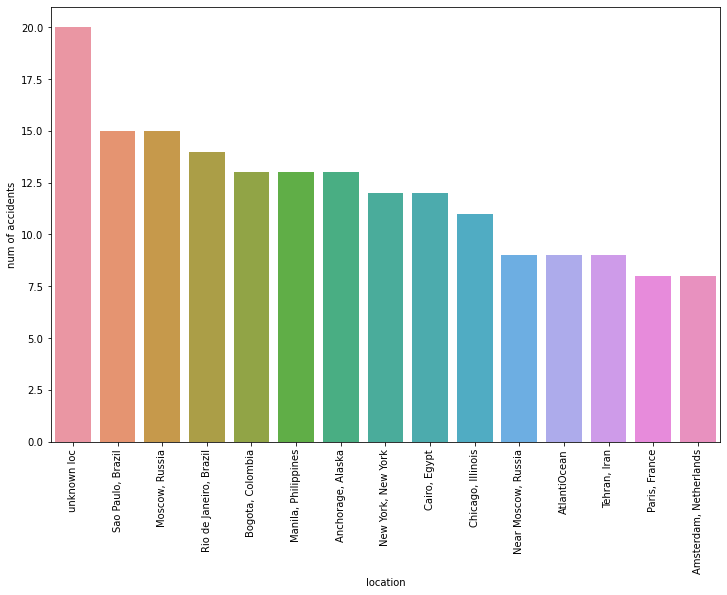

In [37]:
sns.barplot(x='location', y='num of accidents', data=loc_cr[:15])
plt.xticks(rotation=90);

At first glance, there are a lot of entering mistakes (AtlantiOcean), doubles (Moscow and Near Moscow)and also some unknowns. Country preprocessing would have given a different result

Let's examine summary of the crash

In [38]:
data['Summary'].head(10)

0    During a demonstration flight, a U.S. Army fly...
1    First U.S. dirigible Akron exploded just offsh...
2    The first fatal airplane accident in Canada oc...
3    The airship flew into a thunderstorm and encou...
4    Hydrogen gas which was being vented was sucked...
5    Crashed into trees while attempting to land af...
6    Exploded and burned near Neuwerk Island,  when...
7           Crashed near the Black Sea, cause unknown.
8    Shot down by British aircraft crashing in flames.
9    Shot down in flames by the British 39th Home D...
Name: Summary, dtype: object

In [39]:
stop = stopwords.words('english')
newStopword = ['aircraft', 'pilot', 'en route', 'airport', 'plane', 'crashed']
stop.extend(newStopword)

drawing a simple Word Cloud of the most common 200 words (excluding updated list of stopwords)

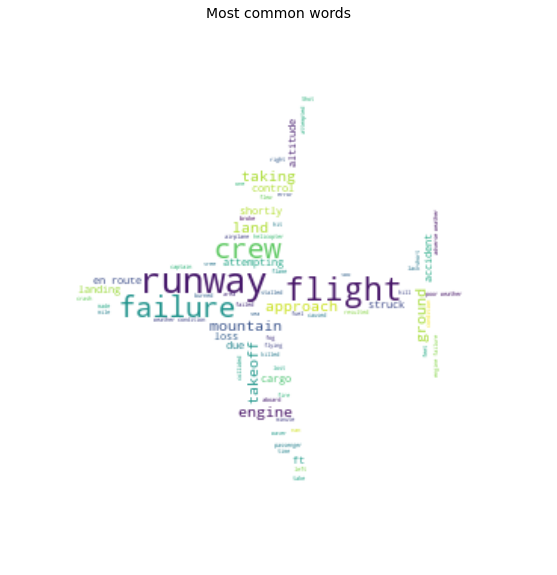

In [40]:
text = str(data['Summary'].tolist())

im = Image.open('plane.jpg')
im = im.rotate(90)
mask = np.array(im)


wc = WordCloud(background_color="white", max_words=200, mask=mask,
               stopwords=stop)
wc.generate(text)

plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title('Most common words', loc='Center', fontsize=14);

this is a very nice picture of the plane, if you couldn't tell :)

lets see whats the most common combination of two words since one word doesn't give us the whole picture

In [41]:
def remove_punct(s):
    punct = set(string.punctuation)
    return ''.join([i for i in s if i not in punct])


In [42]:
temp = data[['Summary','Fatalities']].dropna()
all_summary = temp['Summary'].str.lower().apply(remove_punct).str.split().values
all_summary = [item for sublist in all_summary for item in sublist]

words = [w for w in all_summary if w not in stop]

In [43]:
bigrams = list(bigrams(words))
fdistBigram = FreqDist(bigrams)



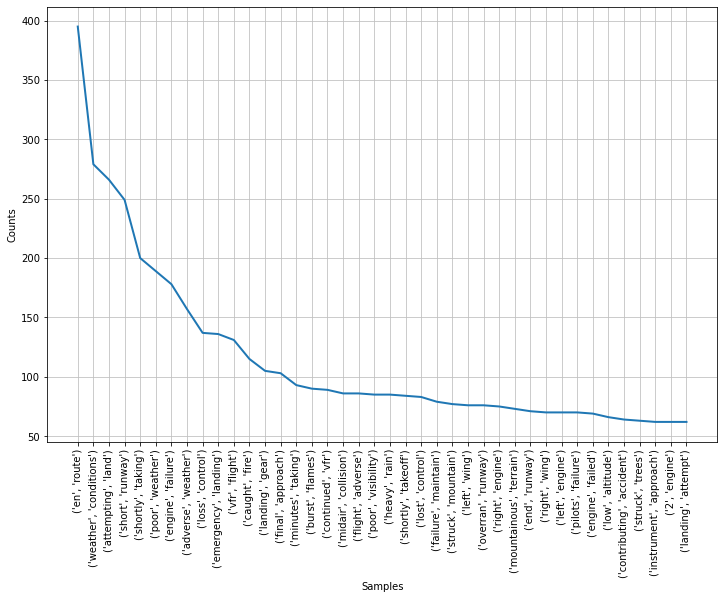

In [44]:
plt.figure(figsize=(15,15))
fdistBigram.plot(40);

vfr = visual flight rules, if you are curious!